## Initialisation

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import sklearn
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
X = heart_disease.data.features
y = heart_disease.data.targets

## Visualisation

I've just done some basic visualisation to understand the dataset a bit more. Feel free to ignore this or add to it.

In [31]:
heart_disease.metadata.num_instances

303

In [25]:
print(heart_disease.metadata.additional_info.summary)

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  In particular, the Cleveland database is the only one that has been used by ML researchers to date.  The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).  
   
The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

One file has been "processed", that one containing the Cleveland database.  All four unprocessed files also exist in this directory.

To see Test Costs (donated by Peter Turney), please see the folder "Costs" 


In [58]:
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [28]:
heart_disease.variables.loc[
    heart_disease.variables['name'] == 'ca', 
    'description'
].iloc[0]

'number of major vessels (0-3) colored by flourosopy'

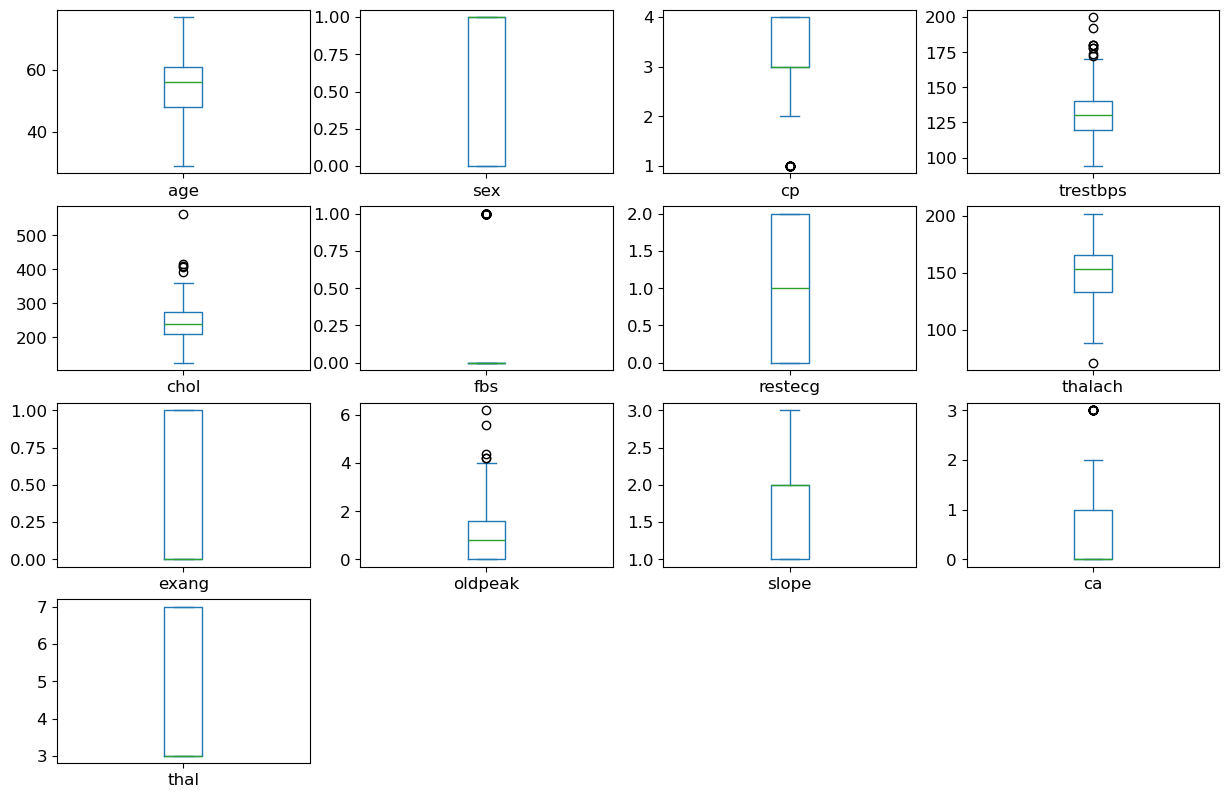

In [15]:
data_mean = heart_disease.data.features.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False, 
sharey=False, fontsize=12, figsize=(15,20));

In [16]:
heart_disease.data.features.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


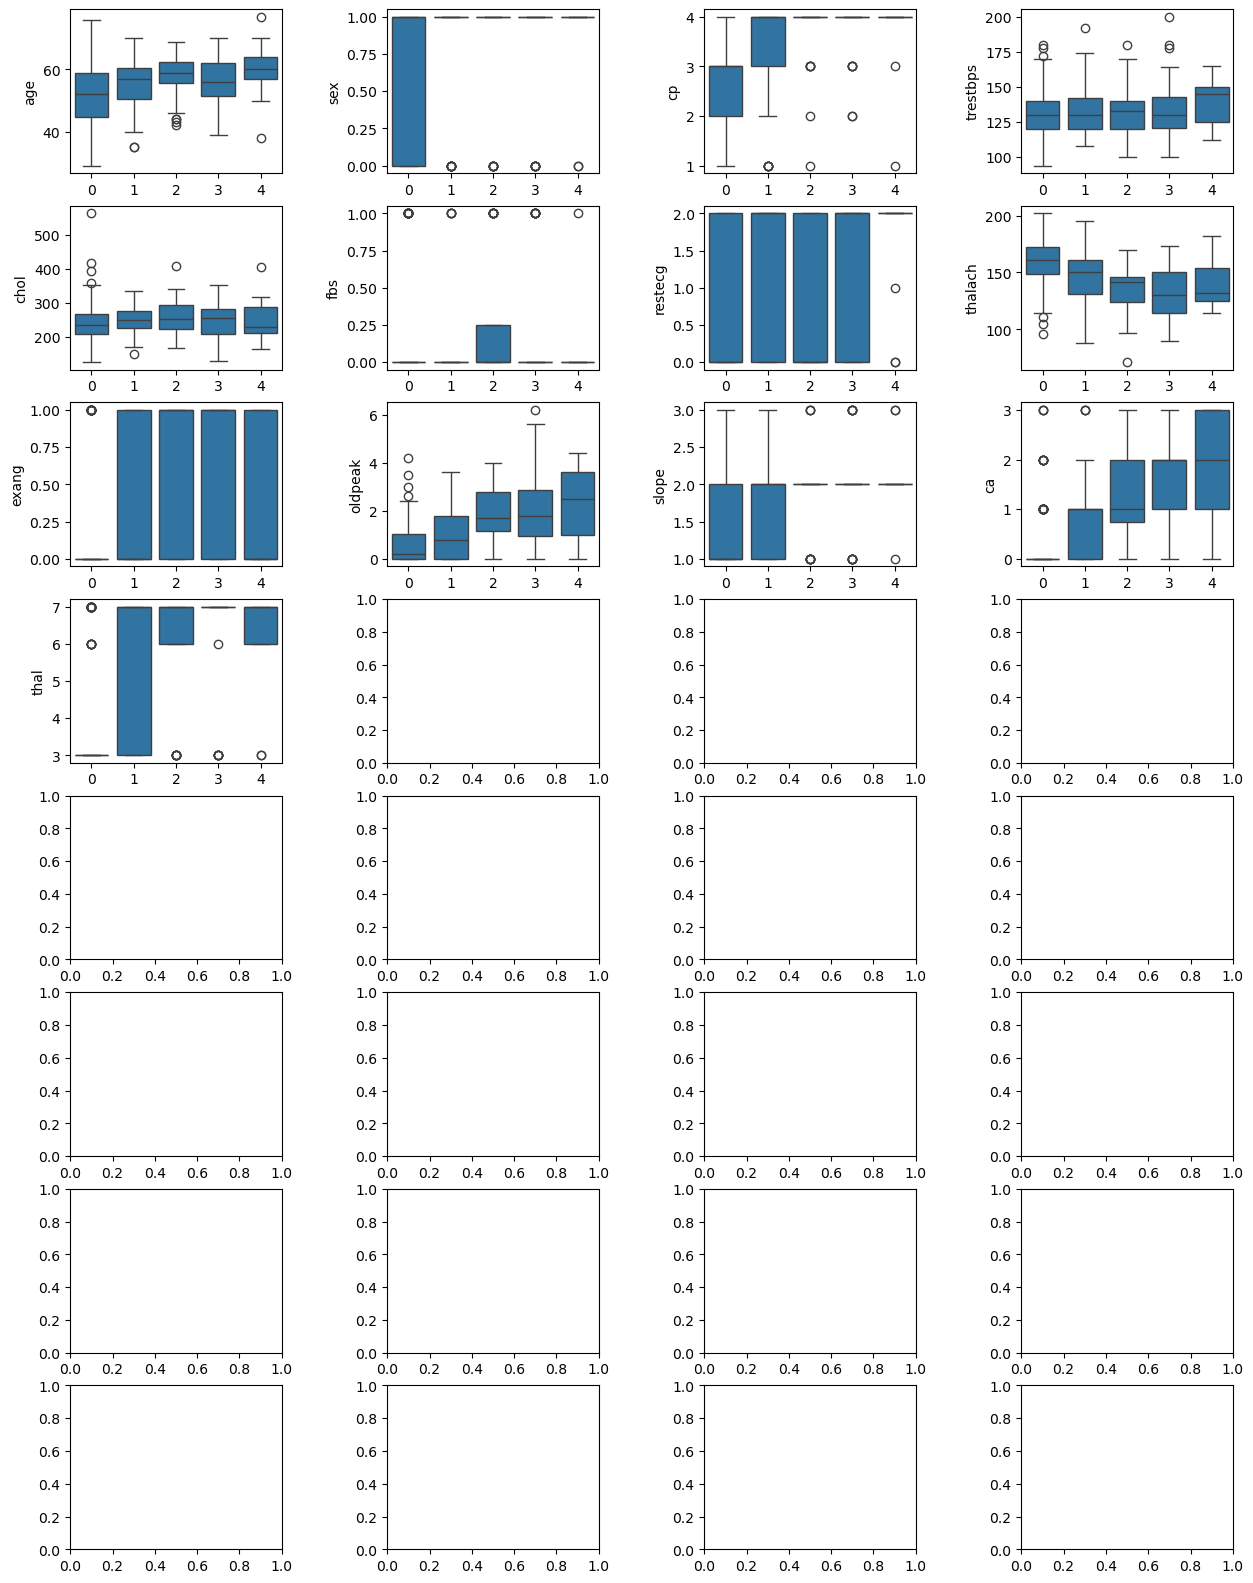

In [25]:
# Combine features and target into one DataFrame
df = pd.concat([heart_disease.data.features, heart_disease.data.targets], axis=1)

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20))
fig.subplots_adjust(hspace=.2, wspace=.5)
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):  # assuming 'num' is the last column
    sns.boxplot(y=col, x='num', data=df, ax=axes[i])

## Data Pre-processing

### Handling Null Data

In [3]:
# features "thal" and "ca" can both only contain fixed values, so we have to drop any missing records.
X = X.dropna()

# Ensure y matches the same indices as X
y = y.loc[X.index]

# Convert to int if needed
y = y.astype(int)

print(X.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


### Feature Encoding

In [4]:
#one-hot encode nominal categories
X = pd.get_dummies(X, columns=['cp', 'restecg', 'thal'], drop_first=True)

#ordinal encode slope by changing its type from categorial to int
X['slope'] = X['slope'].astype(int)

# leave bindary encoding as is but change to int just in case it gets loaded in as a string
X[['sex', 'fbs', 'exang']] = X[['sex', 'fbs', 'exang']].astype(int)

# make all booleans numeric
X = X.astype(int)

print(X.head())
print(X.shape)

   age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  slope  ca  cp_2  \
0   63    1       145   233    1      150      0        2      3   0     0   
1   67    1       160   286    0      108      1        1      2   3     0   
2   67    1       120   229    0      129      1        2      2   2     0   
3   37    1       130   250    0      187      0        3      3   0     0   
4   41    0       130   204    0      172      0        1      1   0     1   

   cp_3  cp_4  restecg_1  restecg_2  thal_6.0  thal_7.0  
0     0     0          0          1         1         0  
1     0     1          0          1         0         0  
2     0     1          0          1         0         1  
3     1     0          0          0         0         0  
4     0     0          0          1         0         0  
(297, 17)


In [5]:
print(X.shape)
print(y.value_counts())
print("3", np.isnan(X).sum().sum())  # should be 0
print("4", np.isnan(y).sum())        # should be 0

(297, 17)
num
0      160
1       54
2       35
3       35
4       13
Name: count, dtype: int64
3 0
4 num    0
dtype: int64


### Convert to CSV

In [6]:
X.to_csv("preprocessed_heart_disease_X.csv", index=False)
y.to_csv("preprocessed_heart_disease_y.csv", index=False)